# Homework 2

## FINM 37400 - 2023

### UChicago Financial Mathematics


In [22]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
pd.set_option("display.precision", 4)

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

In [2]:
QUOTE_DATE = '2015-08-15'

filepath_rawdata = f'../data/treasury_ts_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata, sheet_name=1)
rawdata.head()

,kytreasno,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg
0,204046,2.0151e+07,1989-05-02,116.0625,116.3125,116.1875,M,R,2.2307,0.0058,0.0002,3662.9635,6470.0,7150.0,0.0,NaN,NaN
1,204046,2.0151e+07,1989-05-03,116.1875,116.4375,116.3125,M,R,2.2600,0.0013,0.0002,3664.5035,6470.0,7150.0,0.0,NaN,NaN
2,204046,2.0151e+07,1989-05-04,115.5938,115.8438,115.7188,M,R,2.2894,-0.0048,0.0002,3651.5041,6470.0,7150.0,0.0,NaN,NaN
3,204046,2.0151e+07,1989-05-05,116.2188,116.4688,116.3438,M,R,2.3187,0.0055,0.0002,3663.1657,6470.0,7150.0,0.0,NaN,NaN
4,204046,2.0151e+07,1989-05-08,115.7188,115.9688,115.8438,M,R,2.4068,-0.0035,0.0002,3650.0999,6470.0,7150.0,0.0,NaN,NaN


In [3]:
data = rawdata[(rawdata["kytreasno"] == 204046) |( rawdata["kytreasno"] == 204047)].copy()
display(data[data["caldt"] == "2008-11-04"])

,kytreasno,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg
4178,204047,2.0151e+07,2008-11-04,105.9531,105.9844,105.9688,M,X,0.9355,0.0116,8.8603e-05,2168.0166,20998.0,32470.0,0.0,NaN,NaN
5834,204046,2.0151e+07,2008-11-04,141.8594,141.8906,141.8750,M,X,2.3387,0.0097,9.7885e-05,1910.3079,2852.0,4024.0,0.0,NaN,NaN


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [4]:
def duratn_to_modified(duratn, coupon):
    return 1/(1+coupon/2/100) * duratn

In [5]:
data["dirty price"] = 0.5 * (data["tdbid"] + data["tdask"]) + data["tdaccint"]
data["duration"] = data["tdduratn"] / 365.25
data["ytm"] = data["tdyld"] * 365
compare_set = data.loc[data["caldt"] == "2008-11-04", ["kytreasno", "caldt", "tdbid", "tdask", "tdaccint", "dirty price", "duration", "ytm"]].copy()

In [6]:
info_data = pd.read_excel(filepath_rawdata, sheet_name=0, header=1)
compare_set["coupon rate"] = info_data.loc[info_data["kytreasno"] == "tcouprt", [204046, 204047]].values.T
compare_set["modified duration"] = compare_set.apply(lambda row: duratn_to_modified(row["duration"], row["coupon rate"]), axis=1)
compare_set

,kytreasno,caldt,tdbid,tdask,tdaccint,dirty price,duration,ytm,coupon rate,modified duration
4178,204047,2008-11-04,105.9531,105.9844,0.9355,106.9042,5.9357,0.0323,10.625,5.6363
5834,204046,2008-11-04,141.8594,141.8906,2.3387,144.2137,5.2301,0.0357,4.25,5.1213


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [7]:
# i: 204046	 : 5834
# j: 204047  : 4178
compare_set["dollar duration"] = compare_set["duration"] * compare_set["dirty price"]
compare_set.loc[5834, "total dollar"] = 50 * 1000000
compare_set.loc[5834, "position"] =compare_set.loc[5834, "total dollar"] /  compare_set.loc[5834, "dirty price"]
compare_set.loc[4178, "position"] = - compare_set.loc[5834, "position"] * compare_set.loc[5834, "dollar duration"]\
          / compare_set.loc[4178, "dollar duration"]
compare_set.loc[4178, "total dollar"] = compare_set.loc[4178, "position"] * compare_set.loc[4178, "dirty price"]
compare_set[["kytreasno", "position", "total dollar"]]

,kytreasno,position,total dollar
4178,204047,-412112.6579,-4.4057e+07
5834,204046,346707.8068,5.0000e+07


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

### Answer:

$$ - PnL = D_{ytm, i}*(-0.5Bp)*Pos_i*p_i + D_{ytm, j}*(+0.5Bp)*Pos_j*p_j $$



In [8]:
compare_set["chg"] = [1, -1]
print("Expected PnL for one basis of change: ")
(- compare_set["modified duration"] * compare_set["chg"] * compare_set["position"] * compare_set["dirty price"] * 0.5 * 0.0001).sum()

Expected PnL for one basis of change: 


25219.03269528166

In [9]:
print("Expected PnL for 17bps of change: ")
(- 17 * compare_set["modified duration"] * compare_set["chg"] * compare_set["position"] * compare_set["dirty price"] * 0.5 * 0.0001).sum()

Expected PnL for 17bps of change: 


428723.55581978825

## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

**Answer:**
- The loss in this case makes sense, since for 2008-11-25 both the bond and note's YTM went down by ~0.5bps instead of converging. Likewise for 2008-12-16, both the bond and note's YTM went down by ~1.7bps instead of converging.
- If the spread had converged, we would have observed a profit similar to the result in 1.3

In [10]:
d1 = data[data["caldt"] == "2008-11-25"]
((d1["dirty price"].values - compare_set["dirty price"].values) * compare_set["position"]).sum()

-499072.8163001358

In [11]:
d2 = data[data["caldt"] == "2008-12-16"]
((d2["dirty price"].values - compare_set["dirty price"].values) * compare_set["position"]).sum()

-1049332.7543288777

***

# 2 Calculating Duration

Use the data file `../data/treasury_quotes_2022-09-30.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

In [12]:
QUOTE_DATE = '2022-09-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [13]:
rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
metrics['yld'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = rawprices

metrics

,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,,
207892,2022-06-07,2022-10-04,NaN,0.000,0.0243,0.0110,0.0110,99.9734
207774,2021-10-07,2022-10-06,NaN,0.000,0.0237,0.0164,0.0164,99.9610
207893,2022-06-14,2022-10-11,NaN,0.000,0.0248,0.0301,0.0301,99.9251
207868,2022-04-14,2022-10-13,NaN,0.000,0.0259,0.0356,0.0356,99.9077
207430,2019-10-15,2022-10-15,2.3235e+10,1.375,0.0287,0.0411,0.0411,100.5686
...,...,...,...,...,...,...,...,...
207808,2021-11-15,2051-11-15,6.8972e+10,1.875,0.0379,20.5062,29.1253,66.6406
207849,2022-02-15,2052-02-15,6.3004e+10,2.250,0.0378,19.9829,29.3771,72.7188
207850,2022-02-15,2052-02-15,1.6633e+10,0.125,NaN,NaN,29.3771,62.9102


## 2.1 
Set up the cashflow matrix. 

### Answers: 
**Filter treasuries like HW1.**  

In [16]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

In [17]:
data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [18]:
CF.head()

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*


### Answers:


**Spot curve**

$$r(t,T) = e^{r(T-t)}-1$$

**Discountt curve**

$\displaystyle\text{discount} \equiv \; Z(t,T) = \frac{1}{\left(1+\frac{r_n}{n}\right)^{n(T-t)}} \; = e^{-r(T-t)}$




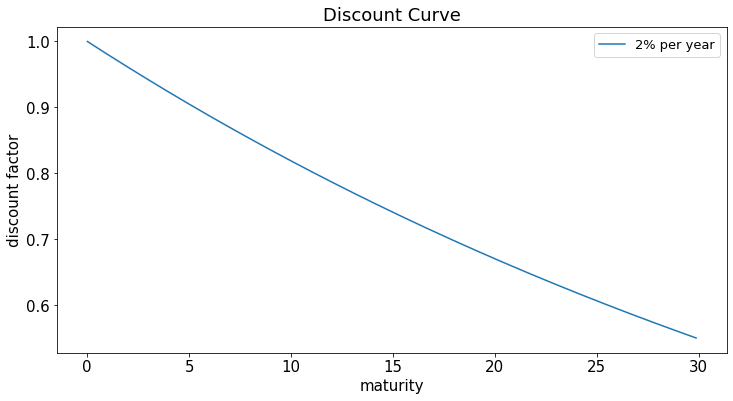

In [23]:
# nlds_grid = np.arange(0.01, 30, 0.01)
maturity = get_maturity_delta(CF.columns, t_current)

def get_discount_grid(maturity, rate):
    discount_grid = pd.DataFrame(data=np.zeros([len(maturity), 1]), index=maturity, columns=["2% per year"])
    spot_grid = pd.DataFrame(data=np.zeros([len(maturity), 1]), index=maturity, columns=["2% per year"])
    for n in maturity:
        spot_grid.loc[n, "2% per year"] = np.exp(rate*n) - 1
        discount_grid.loc[n, "2% per year"] = np.exp(-rate*n)

    return spot_grid, discount_grid

spot_grid, discount_grid = get_discount_grid(maturity, 0.02)
discount_grid.plot()
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve')
plt.show()

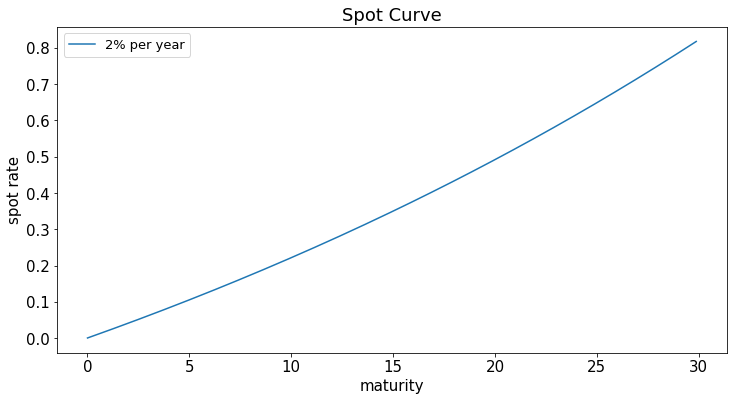

In [24]:
spot_grid.plot()
plt.xlabel('maturity')
plt.ylabel('spot rate')
plt.title('Spot Curve')
plt.show()

## 2.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)

In [25]:
CF_prices = CF * discount_grid.values.T
model_prices = CF_prices.sum(axis=1)

CF_wts = CF_prices.div(model_prices,axis=0)
# display(CF_wts.iloc[-5:,-10:].style.format('{:.2%}'))
model_duration = (CF_wts * maturity).sum(axis=1)

In [26]:
model_duration = model_duration.to_frame("Duration")
model_duration.describe()

,Duration
count,378.0000
mean,5.1507
std,6.0130
min,0.0110
25%,0.8824
50%,2.7516
75%,5.9910
max,22.8334



## 2.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

### Answers: 
- There does not exist much difference in these two durations, as we can see from the description and the histogram, most of the differences fall from -0.25 to 0, and the maximum difference is 2. 
- Longer the duration, the higher the model bias. As we can see from the histogram, modeled duration is shorter than the database duration. 
- However, it still gets higher range of difference compared to the estimation we saw from the class. The assumption causes model discount factor to differ from the real-life discount factor. Especially for long-term spot rate, under the assumption of continuous compounding, interest rate rises to a very high level. 

In [27]:
duration = model_duration.merge(data[["TDDURATN"]]/365.25, left_index=True, right_index=True)
duration

,Duration,TDDURATN
KYTREASNO,,
207892,0.0110,0.0110
207774,0.0164,0.0164
207893,0.0301,0.0301
207868,0.0356,0.0356
207430,0.0411,0.0411
...,...,...
207763,22.0094,20.2485
207808,22.2928,20.4922
207849,21.8255,19.9692


In [28]:
duration["diff"] = duration["TDDURATN"] - duration["Duration"]
duration[["diff"]].describe()

,diff
count,3.7800e+02
mean,-2.1279e-01
std,4.6986e-01
min,-1.9584e+00
25%,-3.4362e-02
50%,-2.9476e-03
75%,-1.7922e-05
max,3.7003e-05


Text(0, 0.5, 'Count')

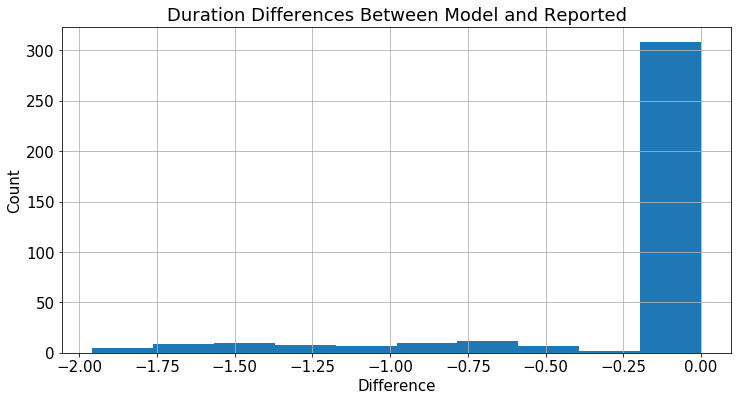

In [29]:
duration[["diff"]].hist()
plt.title('Duration Differences Between Model and Reported')
plt.xlabel('Difference')
plt.ylabel('Count')


## 2.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

In [30]:
model_convexity = (CF_wts * maturity**2).sum(axis=1)
model_convexity.describe().to_frame("Convexity")

,Convexity
count,378.0000
mean,72.7792
std,141.0279
min,0.0001
25%,0.7798
50%,7.7340
75%,37.5715
max,590.9946


# 3 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`

## 3.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)

In [31]:
filepath_tsdata = "../data/treasury_ts_issue_duration_(207392, 207391, 207457).xlsx"
tsdata = pd.read_excel(filepath_tsdata, sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT', columns='KYTREASNO', values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT', columns='KYTREASNO', values='TDDURATN').dropna()

In [32]:
duration = duration/365.25

In [33]:
ts_hedge = pd.DataFrame()
ts_hedge["price"] = px.iloc[-1, :2]
ts_hedge["duration"] = duration.iloc[-1, :2]
ts_hedge["position"] = 10000 / px.iloc[-1, :2]
ts_hedge.loc[207392, "position"] = - ts_hedge.loc[207391, "position"] * ts_hedge.loc[207391, "duration"] * ts_hedge.loc[207391, "price"]/(ts_hedge.loc[207392, "duration"] * ts_hedge.loc[207392, "price"])

In [34]:
ts_hedge["total dollar"] = ts_hedge["price"] * ts_hedge["position"]
ts_hedge

,price,duration,position,total dollar
KYTREASNO,,,,
207391,92.1719,6.7777,108.4930,10000.000
207392,83.8438,19.6022,-41.2388,-3457.617


## 3.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

In [35]:
px = px[[207391, 207392]].copy()
duration = duration[[207391, 207392]].copy()

In [36]:
dynamic_hedge = 10000 / px
dynamic_hedge[207392] = - dynamic_hedge[207391] * duration[207391] * px[207391] / (duration[207392] * px[207392])
dynamic_hedge

KYTREASNO,207391,207392
CALDT,,
2019-12-10,101.9677,-41.4669
2019-12-11,101.5148,-41.0494
2019-12-12,102.4246,-41.9388
2019-12-13,101.7893,-41.2905
2019-12-16,102.1956,-41.6440
...,...,...
2022-05-24,107.7895,-40.4107
2022-05-25,107.6716,-40.3172
2022-05-26,107.6807,-40.6285


In [37]:
px_chg = px.shift() - px
pnl_series = (dynamic_hedge.shift() * px_chg).sum(axis=1)
pnl_series

CALDT
2019-12-10     0.0000
2019-12-11    -9.9471
2019-12-12    14.7441
2019-12-13    -8.6809
2019-12-16     8.4710
               ...   
2022-05-24   -22.1890
2022-05-25    -4.9489
2022-05-26   -21.5223
2022-05-27    15.9505
2022-05-31    13.1835
Length: 621, dtype: float64

In [38]:
print("Total profit: " + str(pnl_series.sum()))

Total profit: 240.90969692598856


In [39]:
pnl_series.describe().to_frame("Daily profit & loss")

,Daily profit & loss
count,621.0000
mean,0.3879
std,18.7825
min,-107.6361
25%,-9.2217
50%,0.0752
75%,9.7683
max,98.3180


***